In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess


## Code from Krish (August 1, 2024 in Slack)

In [2]:
data_size = 10**4
sim_size = 10**5
n_iterations = 5
n_bootstraps = 500
epsilon = 1e-8
rcond = 1e-3

rng_seed = 5048
rng = np.random.default_rng(seed = rng_seed )

mu_true, var_true = 0.2, 0.81
mu_gen, var_gen = 0.0, 1.0


#smearing = 0.00001
smearing = 0.25
#smearing = 0.50
#smearing = 0.75

min_bin_width = 0.20


output_dir = 'input-samples-smearing-%.2f-v1a' % smearing


In [3]:
truth = rng.normal(mu_true, np.sqrt(var_true), (n_bootstraps, data_size))
data = rng.normal(truth, smearing)
gen = rng.normal(mu_gen, np.sqrt(var_gen), (n_bootstraps, sim_size))
sim = rng.normal(gen, smearing)

In [4]:
bins = [truth.min()]
i = 0
while bins[-1] < truth.max() and i < len(bins):
    for binhigh in np.linspace(bins[i] + epsilon, truth.max(), 200):
        in_bin = (truth[0] > bins[i]) & (truth[0] < binhigh)
        in_reco_bin = (data[0] > bins[i]) & (data[0] < binhigh)
        if np.sum(in_bin) > 0:
            purity = np.sum(in_bin & in_reco_bin) / np.sum(in_bin)
            if purity > (0.5):
                binwid = binhigh - bins[-1]
                if binwid < min_bin_width :
                    binhigh = bins[-1] + min_bin_width
                #print(f"{binhigh = }, {purity = }")
                print(' %3d :  binhigh = %7.3f, purity = %7.3f' % (i, binhigh, purity))
                i += 1
                bins.append(binhigh)
                break
    else:
        break
        
#-- add a last bin
bins.append(truth.max())
        
bins = np.array(bins[1:-1])
bin_widths = np.diff(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
n_bins = len(bins) - 1

   0 :  binhigh =  -3.339, purity =   1.000
   1 :  binhigh =  -2.920, purity =   1.000
   2 :  binhigh =  -2.720, purity =   1.000
   3 :  binhigh =  -2.520, purity =   0.625
   4 :  binhigh =  -2.105, purity =   0.611
   5 :  binhigh =  -1.748, purity =   0.532
   6 :  binhigh =  -1.375, purity =   0.508
   7 :  binhigh =  -0.991, purity =   0.539
   8 :  binhigh =  -0.600, purity =   0.516
   9 :  binhigh =  -0.206, purity =   0.534
  10 :  binhigh =   0.186, purity =   0.520
  11 :  binhigh =   0.572, purity =   0.514
  12 :  binhigh =   0.950, purity =   0.509
  13 :  binhigh =   1.357, purity =   0.525
  14 :  binhigh =   1.759, purity =   0.508
  15 :  binhigh =   2.149, purity =   0.508
  16 :  binhigh =   2.535, purity =   0.515
  17 :  binhigh =   2.943, purity =   0.528
  18 :  binhigh =   3.211, purity =   0.571
  19 :  binhigh =   3.803, purity =   1.000


## End code from Krish.  My stuff below here.

In [5]:
bins

array([-3.33891579, -2.92013449, -2.72013449, -2.52013449, -2.10473433,
       -1.7479722 , -1.37525438, -0.99112856, -0.60008591, -0.2064736 ,
        0.18558461,  0.57225777,  0.95006562,  1.3565748 ,  1.75879418,
        2.14907009,  2.53517848,  2.94306071,  3.21113133,  3.80271041])

In [6]:
print('\n\n')
for bi in range(len(bins)-1) :
    bw = bins[bi+1]-bins[bi]
    print(' %3d :  %7.3f to %7.3f,  bin width = %7.3f' % (bi, bins[bi], bins[bi+1], bw))
print('\n\n')




   0 :   -3.339 to  -2.920,  bin width =   0.419
   1 :   -2.920 to  -2.720,  bin width =   0.200
   2 :   -2.720 to  -2.520,  bin width =   0.200
   3 :   -2.520 to  -2.105,  bin width =   0.415
   4 :   -2.105 to  -1.748,  bin width =   0.357
   5 :   -1.748 to  -1.375,  bin width =   0.373
   6 :   -1.375 to  -0.991,  bin width =   0.384
   7 :   -0.991 to  -0.600,  bin width =   0.391
   8 :   -0.600 to  -0.206,  bin width =   0.394
   9 :   -0.206 to   0.186,  bin width =   0.392
  10 :    0.186 to   0.572,  bin width =   0.387
  11 :    0.572 to   0.950,  bin width =   0.378
  12 :    0.950 to   1.357,  bin width =   0.407
  13 :    1.357 to   1.759,  bin width =   0.402
  14 :    1.759 to   2.149,  bin width =   0.390
  15 :    2.149 to   2.535,  bin width =   0.386
  16 :    2.535 to   2.943,  bin width =   0.408
  17 :    2.943 to   3.211,  bin width =   0.268
  18 :    3.211 to   3.803,  bin width =   0.592





In [7]:
sim_scale_factor = (1.*data_size)/(1.*sim_size)
sim_simple_weights = sim_scale_factor*np.ones(shape=(sim_size))

<function matplotlib.pyplot.show(close=None, block=None)>

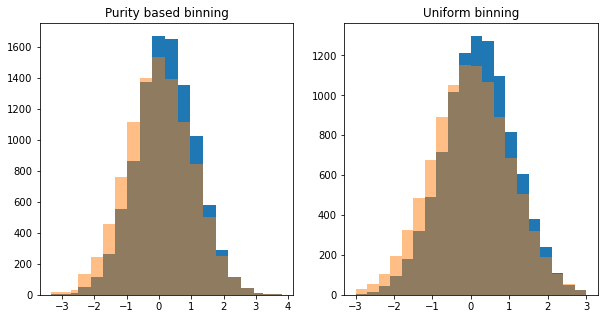

In [8]:

phbins=20
pxmin=-3.
pxmax=3.


fig,ax = plt.subplots( 1, 2, figsize=(2*5,5))

axi = ax[0]
axi.hist( data[0,:], bins=bins)
axi.hist( sim[0,:], bins=bins, weights=sim_simple_weights, alpha=0.5)

axi = ax[1]
plt.hist( data[0,:], bins=phbins, range=[pxmin,pxmax] )
plt.hist( sim[0,:], bins=phbins, range=[pxmin,pxmax], weights=sim_simple_weights, alpha=0.5 )

ax[0].set_title('Purity based binning')
ax[1].set_title('Uniform binning')


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

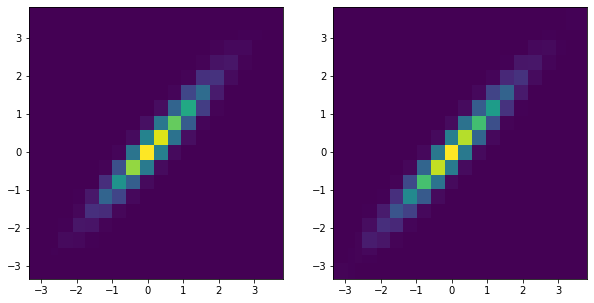

In [9]:


fig,ax = plt.subplots( 1, 2, figsize=(2*5,5))

axi = ax[0]
h2d_data,_,_,_ = axi.hist2d( truth[0,:], data[0,:], bins=[bins,bins])

axi = ax[1]
h2d_sim,_,_,_ = axi.hist2d( gen[0,:], sim[0,:], bins=[bins,bins])

plt.show


   0 :  max data    1.000,   max sim    0.717
   1 :  max data    1.000,   max sim    0.326
   2 :  max data    0.625,   max sim    0.338
   3 :  max data    0.611,   max sim    0.540
   4 :  max data    0.532,   max sim    0.484
   5 :  max data    0.508,   max sim    0.493
   6 :  max data    0.539,   max sim    0.512
   7 :  max data    0.516,   max sim    0.524
   8 :  max data    0.534,   max sim    0.521
   9 :  max data    0.520,   max sim    0.528
  10 :  max data    0.514,   max sim    0.515
  11 :  max data    0.509,   max sim    0.515
  12 :  max data    0.525,   max sim    0.539
  13 :  max data    0.508,   max sim    0.538
  14 :  max data    0.508,   max sim    0.521
  15 :  max data    0.515,   max sim    0.523
  16 :  max data    0.528,   max sim    0.532
  17 :  max data    0.571,   max sim    0.374
  18 :  max data    1.000,   max sim    0.732


<function matplotlib.pyplot.show(close=None, block=None)>

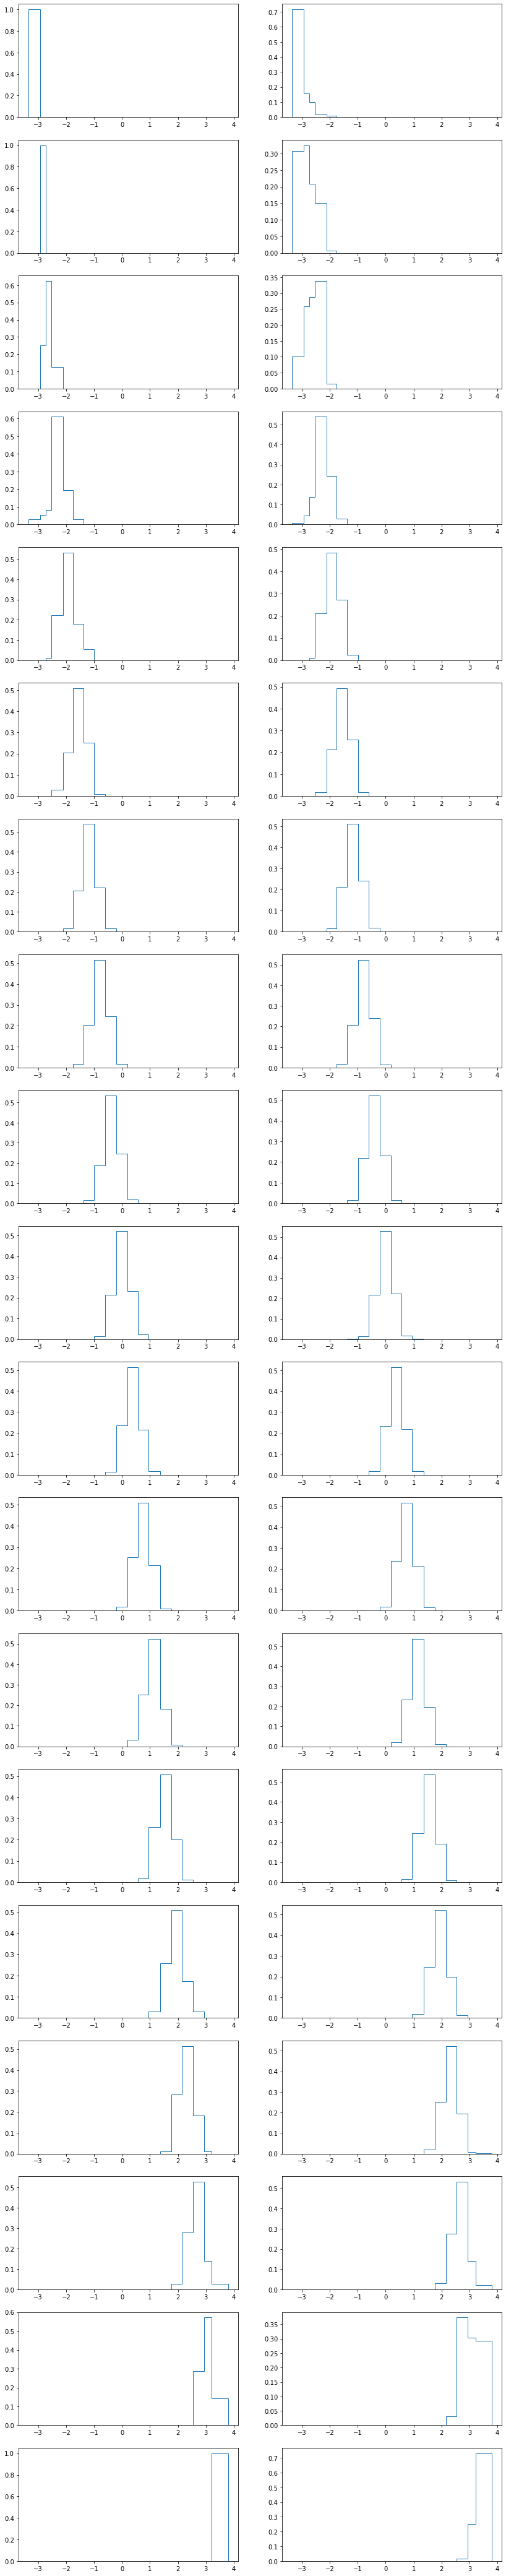

In [10]:
fig,ax = plt.subplots( n_bins, 2, figsize=(2*7,n_bins*4))

for bi in range(n_bins) :
    
    axi=ax[bi,0]
    hsum = np.sum(h2d_data[bi,:])
    axi.stairs( (1./hsum)*h2d_data[bi,:], edges=bins )
    max_data = np.max( (1./hsum)*h2d_data[bi,:] )
    
    axi=ax[bi,1]
    hsum = np.sum(h2d_sim[bi,:])
    axi.stairs( (1./hsum)*h2d_sim[bi,:], edges=bins )
    max_sim = np.max( (1./hsum)*h2d_sim[bi,:] )
    
    print(' %3d :  max data  %7.3f,   max sim  %7.3f' % (bi, max_data, max_sim ))
    
plt.show

## Write the samples to files in an output directory

In [11]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  input-samples-smearing-0.25-v1a


In [12]:
out_file = '%s/config.txt' % output_dir

text_file = open( out_file, 'w' )

text_file.write( 'data_size %d\n' % data_size )
text_file.write( 'sim_size  %d\n' % sim_size )
text_file.write( 'n_bootstraps %d\n' % n_bootstraps )
text_file.write( 'rng_seed %d\n' % rng_seed  )
text_file.write( 'mu_true  %.4f\n' % mu_true )
text_file.write( 'mu_gen   %.4f\n' % mu_gen )
text_file.write( 'var_true   %.4f\n' % var_true )
text_file.write( 'var_gen    %.4f\n' % var_gen )
text_file.write( 'smearing  %.2f\n' % smearing )
text_file.write( 'min_bin_width  %.4f\n' % min_bin_width )


text_file.close()

print('\n\n')

print( subprocess.getoutput('cat %s' % out_file ))

print('\n\n')







data_size 10000
sim_size  100000
n_bootstraps 500
rng_seed 5048
mu_true  0.2000
mu_gen   0.0000
var_true   0.8100
var_gen    1.0000
smearing  0.25
min_bin_width  0.2000





In [13]:

out_file = '%s/binning.npy' % output_dir
print('\n\n Saving binning in %s\n\n' % out_file )

with open( out_file, 'wb' ) as f :
    np.save( f, bins )
    np.save( f, bin_widths )
    np.save( f, bin_centers )
    np.save( f, n_bins )
    
out_file = '%s/binning.txt' % output_dir
print(' Saving in human readable format: %s\n\n' % out_file )

text_file = open( out_file, 'w' )

text_file.write( 'bins ' )
text_file.write( '%s\n' % str(bins) )

text_file.write( 'bin_widths ' )
text_file.write( '%s\n' % str(bin_widths) )

text_file.write( 'bin_centers ' )
text_file.write( '%s\n' % str(bin_centers) )

text_file.write( 'n_bins ' )
text_file.write( '%s\n' % str(n_bins) )

text_file.close()


print( subprocess.getoutput('cat %s' % out_file ))

print('\n\n')




 Saving binning in input-samples-smearing-0.25-v1a/binning.npy


 Saving in human readable format: input-samples-smearing-0.25-v1a/binning.txt


bins [-3.33891579 -2.92013449 -2.72013449 -2.52013449 -2.10473433 -1.7479722
 -1.37525438 -0.99112856 -0.60008591 -0.2064736   0.18558461  0.57225777
  0.95006562  1.3565748   1.75879418  2.14907009  2.53517848  2.94306071
  3.21113133  3.80271041]
bin_widths [0.4187813  0.2        0.2        0.41540016 0.35676213 0.37271782
 0.38412581 0.39104265 0.39361232 0.39205821 0.38667316 0.37780785
 0.40650918 0.40221938 0.39027591 0.38610839 0.40788223 0.26807061
 0.59157908]
bin_centers [-3.12952514 -2.82013449 -2.62013449 -2.31243441 -1.92635326 -1.56161329
 -1.18319147 -0.79560724 -0.40327975 -0.01044449  0.37892119  0.76116169
  1.15332021  1.55768449  1.95393214  2.34212429  2.7391196   3.07709602
  3.50692087]
n_bins 19





In [14]:
for si in range( n_bootstraps ) :
    
    out_file = '%s/sample-%04d.npy' % ( output_dir, si )
    
    print(' %4d : Saving sample in file %s' % (si, out_file))
    
    with open( out_file, 'wb' ) as f :
        np.save( f, truth[si,:] )
        np.save( f, data[si,:] )
        np.save( f, gen[si,:] )
        np.save( f, sim[si,:] )
    
    

    0 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0000.npy
    1 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0001.npy
    2 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0002.npy
    3 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0003.npy
    4 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0004.npy
    5 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0005.npy
    6 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0006.npy
    7 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0007.npy
    8 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0008.npy
    9 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0009.npy
   10 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0010.npy
   11 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0011.npy
   12 : Saving sample in file input-samples-smearing-0.25-v1a/sa

  146 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0146.npy
  147 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0147.npy
  148 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0148.npy
  149 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0149.npy
  150 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0150.npy
  151 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0151.npy
  152 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0152.npy
  153 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0153.npy
  154 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0154.npy
  155 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0155.npy
  156 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0156.npy
  157 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0157.npy
  158 : Saving sample in file input-samples-smearing-0.25-v1a/sa

  308 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0308.npy
  309 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0309.npy
  310 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0310.npy
  311 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0311.npy
  312 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0312.npy
  313 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0313.npy
  314 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0314.npy
  315 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0315.npy
  316 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0316.npy
  317 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0317.npy
  318 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0318.npy
  319 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0319.npy
  320 : Saving sample in file input-samples-smearing-0.25-v1a/sa

  470 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0470.npy
  471 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0471.npy
  472 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0472.npy
  473 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0473.npy
  474 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0474.npy
  475 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0475.npy
  476 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0476.npy
  477 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0477.npy
  478 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0478.npy
  479 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0479.npy
  480 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0480.npy
  481 : Saving sample in file input-samples-smearing-0.25-v1a/sample-0481.npy
  482 : Saving sample in file input-samples-smearing-0.25-v1a/sa